In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [332]:
from sklearn.cross_validation import train_test_split
from collections import Counter, defaultdict
import math

class NaiveBayesProb:
    
    def __init__(self):
        self.raw_data = False
        pass
    
    def read_raw_data(self):
        self.target_domain = set()
        self.attribute_domains = defaultdict(set)
        self.raw_x = []
        self.raw_y = []
        with open("/Users/rbekbolatov/data/uci/mushroom/agaricus-lepiota.data", "r") as datafile:
            for line in datafile:
                els = line.rstrip('\n').split(',')
                self.raw_y.append(els[0])
                self.raw_x.append(els[1:])
        self.raw_data = True
        
    def train_and_evaluate(self, test_fraction=0.2): 
        self.xs_log_prob_cache = {}
        self.train(test_fraction)
        return self.evaluate()
        
    def train(self, test_fraction=0.2): 
        if not self.raw_data:
            self.read_raw_data()
        x_train, x_test, y_train, y_test = train_test_split(self.raw_x, self.raw_y, test_size=test_fraction, random_state=42)
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.n_train = len(self.y_train)
        self.n_test = len(self.y_test)
        self.count()
        self.optimize_LOGREG()
        
    def count(self):
        self.counts = Counter()
        self.y_counts = Counter()
        for (y, xs) in zip(self.y_train, self.x_train):
            self.y_counts[y] += 1
            self.target_domain.add(y)
            for (i, x) in enumerate(xs):
                self.counts[(i, y, x)] += 1
                self.attribute_domains[i].add(x)
                
    # for logistic regression
    
    def dot(self, aa, bb):
        return sum([a*b for (a,b) in zip(aa,bb)])

    def sigmoid(self, x):
        return 1.0 / (1.0 + math.exp(-x))
    
    def create_features(self):
        self.feature_idx = {}
        idx = 0
        for i, di in self.attribute_domains.items():
            for f in list(di):
                self.feature_idx[(i, f)] = idx
                idx += 1
        
    def encode(self, xs):
        xsi = [0.0]*len(self.feature_idx)
        for i,v in enumerate(xs):
            xsi[self.feature_idx[(i,v)]] = 1.0
        return xsi

    def predict_with_w(self, ws, xs):
        return 1.0 if self.prob_with_w(ws, xs) > 0.5 else 0.0
    
    def prob_with_w(self, ws, xs):
        v = self.dot(ws, xs)
        return self.sigmoid(v)
    
    def optimize_LOGREG(self):        
        self.create_features()
        xs = np.array([self.encode(x) for x in self.x_train])
        w = tuple([0.0]*len(xs[0]))
        data = [(x, 1.0 if y == 'p' else 0.0) for x,y in zip(xs, self.y_train)]
        
        print(sum([1 if self.predict_with_w(w, xs) == y else 0 for (xs, y) in data]) * 1.0 /self.n_train)
        
        
        
    # For generative/NBC
    
    def y_prior_log_prob(self, y):
        return math.log(self.y_counts[y] * 1.0 / self.n_train)
    
    def x_i_class_cond_log_prob(self, idx, x, given_y, lap=1.0):
        return math.log((self.counts[(idx, given_y, x)] + lap) * 1.0 / (self.y_counts[given_y] + lap*len(self.attribute_domains[idx])))
    
    def xs_class_cond_log_prob(self, xs, given_y):
        # Naive Bayes assumption p((x1,..., xk)|y)=p(x1|y)*p(x2|y)*...*p(xk|y)
        return self.xs_class_cond_NB_log_prob(xs, given_y)

    def xs_class_cond_NB_log_prob(self, xs, given_y):
        return sum([self.x_i_class_cond_log_prob(i, xs[i], given_y) for i in range(len(self.attribute_domains))])

    def xs_y_joint_log_prob(self, xs, y):
        return self.y_prior_log_prob(y) + self.xs_class_cond_log_prob(xs, y)

    def xs_log_prob(self, xs):
        # actually, this might be needed only once (after the first call) - so not a lot of gain here. 
        cached = self.xs_log_prob_cache.get(tuple(xs))
        if cached is None:
            cached = math.log(sum([math.exp(self.xs_y_joint_log_prob(xs, y)) for y in self.target_domain]))
            self.xs_log_prob_cache[tuple(xs)] = cached
        return cached

    
    # NBC, After Bayes
    def y_posterior_log_prob_NBC(self, y, given_xs):
        return self.xs_y_joint_log_prob(given_xs, y) - self.xs_log_prob(given_xs)
    
    def y_posterior_prob_NBC(self, y, given_xs):
        return math.exp(self.y_posterior_log_prob_NBC(y, given_xs))
    
    def y_posterior_prob_dist_NBC(self, given_xs):
        return {y: self.y_posterior_prob_NBC(y, given_xs) for y in self.target_domain}
    
    def y_predict_NBC(self, given_xs):
        max_log_prob = None
        max_log_prob_target = None
        for y in self.target_domain:
            prob = self.y_posterior_log_prob_NBC(y, given_xs)
            if max_log_prob is None or max_log_prob < prob:
                max_log_prob = prob
                max_log_prob_target = y
        return (max_log_prob_target, math.exp(max_log_prob))
    
    
    # Logistic regression
    def y_predict_LOGREG(self, given_xs):
        return self.y_predict_NBC(given_xs)
    
    
    
    
    # Evaluate against test set:
    def test_accuracy_NBC(self):
        return sum([1 if self.y_predict_NBC(xs)[0] == y else 0 for (xs, y) in zip(self.x_test, self.y_test)]) * 1.0 / self.n_test
    
    def test_accuracy_LOGREG(self):
        # placeholder
        return sum([1 if self.y_predict_LOGREG(xs)[0] == y else 0 for (xs, y) in zip(self.x_test, self.y_test)]) * 1.0 / self.n_test
    
    
    def evaluate(self):
        baseline_accuracy = 1.0 - math.exp(max([self.y_prior_log_prob(y) for y in self.target_domain]))
        nbc_accuracy = self.test_accuracy_NBC()
        logreg_accuracy = self.test_accuracy_LOGREG()
        print('Baseline accuracy: ' + str(baseline_accuracy))
        print('Naive Bayes classifier accuracy: ' + str(nbc_accuracy))
        print('Logistic Regression classifier accuracy: ' + str(logreg_accuracy))
        return (baseline_accuracy, nbc_accuracy, logreg_accuracy)
        

Cross check with R code:

```R
src <- "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushrooms <- read.table(file = src, header = FALSE, sep = ",")
#head(mushrooms)
#summary(mushrooms)

data = mushrooms
set.seed(101)
indexes = sample(1:nrow(data), size=0.8*nrow(data))
train = data[indexes,]
test = data[-indexes,]

library(e1071)
model <- naiveBayes(V1 ~ ., data=train)
pred <- predict(model, test)
confusionMatrix(pred, test$V1)
```


In [333]:

for i in [0.1]:
    print(i)
    %time NaiveBayesProb().train_and_evaluate(i)

0.1
0.51634523321
Baseline accuracy: 0.48365476679
Naive Bayes classifier accuracy: 0.956949569496
Logistic Regression classifier accuracy: 0.956949569496
CPU times: user 501 ms, sys: 4.82 ms, total: 506 ms
Wall time: 506 ms


In [309]:
xs = np.array(c.x_train)

In [320]:
c = NaiveBayesProb()
c.train_and_evaluate()
c.attribute_domains.items()

[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 ..., 
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]]
Baseline accuracy: 0.482228035082
Naive Bayes classifier accuracy: 0.950769230769
Logistic Regression classifier accuracy: 0.950769230769


[(0, {'b', 'c', 'f', 'k', 's', 'x'}),
 (1, {'f', 'g', 's', 'y'}),
 (2, {'b', 'c', 'e', 'g', 'n', 'p', 'r', 'u', 'w', 'y'}),
 (3, {'f', 't'}),
 (4, {'a', 'c', 'f', 'l', 'm', 'n', 'p', 's', 'y'}),
 (5, {'a', 'f'}),
 (6, {'c', 'w'}),
 (7, {'b', 'n'}),
 (8, {'b', 'e', 'g', 'h', 'k', 'n', 'o', 'p', 'r', 'u', 'w', 'y'}),
 (9, {'e', 't'}),
 (10, {'?', 'b', 'c', 'e', 'r'}),
 (11, {'f', 'k', 's', 'y'}),
 (12, {'f', 'k', 's', 'y'}),
 (13, {'b', 'c', 'e', 'g', 'n', 'o', 'p', 'w', 'y'}),
 (14, {'b', 'c', 'e', 'g', 'n', 'o', 'p', 'w', 'y'}),
 (15, {'p'}),
 (16, {'n', 'o', 'w', 'y'}),
 (17, {'n', 'o', 't'}),
 (18, {'e', 'f', 'l', 'n', 'p'}),
 (19, {'b', 'h', 'k', 'n', 'o', 'r', 'u', 'w', 'y'}),
 (20, {'a', 'c', 'n', 's', 'v', 'y'}),
 (21, {'d', 'g', 'l', 'm', 'p', 'u', 'w'})]

In [334]:
c.feature_idx

{(0, 'b'): 1,
 (0, 'c'): 0,
 (0, 'f'): 2,
 (0, 'k'): 3,
 (0, 's'): 4,
 (0, 'x'): 5,
 (1, 'f'): 3,
 (1, 'g'): 2,
 (1, 's'): 1,
 (1, 'y'): 0,
 (2, 'b'): 1,
 (2, 'c'): 0,
 (2, 'e'): 2,
 (2, 'g'): 3,
 (2, 'n'): 4,
 (2, 'p'): 5,
 (2, 'r'): 6,
 (2, 'u'): 7,
 (2, 'w'): 8,
 (2, 'y'): 9,
 (3, 'f'): 1,
 (3, 't'): 0,
 (4, 'a'): 0,
 (4, 'c'): 1,
 (4, 'f'): 2,
 (4, 'l'): 4,
 (4, 'm'): 3,
 (4, 'n'): 5,
 (4, 'p'): 6,
 (4, 's'): 7,
 (4, 'y'): 8,
 (5, 'a'): 0,
 (5, 'f'): 1,
 (6, 'c'): 0,
 (6, 'w'): 1,
 (7, 'b'): 0,
 (7, 'n'): 1,
 (8, 'b'): 0,
 (8, 'e'): 1,
 (8, 'g'): 2,
 (8, 'h'): 3,
 (8, 'k'): 4,
 (8, 'n'): 6,
 (8, 'o'): 5,
 (8, 'p'): 7,
 (8, 'r'): 8,
 (8, 'u'): 9,
 (8, 'w'): 10,
 (8, 'y'): 11,
 (9, 'e'): 0,
 (9, 't'): 1,
 (10, '?'): 4,
 (10, 'b'): 2,
 (10, 'c'): 1,
 (10, 'e'): 3,
 (10, 'r'): 0,
 (11, 'f'): 3,
 (11, 'k'): 2,
 (11, 's'): 1,
 (11, 'y'): 0,
 (12, 'f'): 3,
 (12, 'k'): 1,
 (12, 's'): 2,
 (12, 'y'): 0,
 (13, 'b'): 1,
 (13, 'c'): 0,
 (13, 'e'): 2,
 (13, 'g'): 3,
 (13, 'n'): 5,
 (13, 'o'): 4,

In [336]:
from sklearn import datasets
iris = datasets.load_iris()

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)
print("Number of mislabeled points out of a total %d points : %d" % (iris.data.shape[0],(iris.target != y_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


In [337]:
from sklearn import datasets

In [338]:
a = datasets.load_iris()

In [344]:
a.data[:10]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1]])

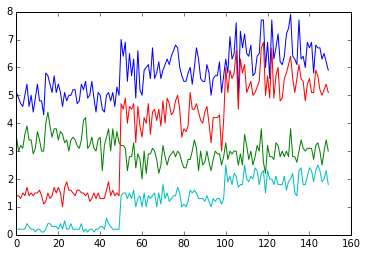

In [343]:
plt(a.data)

[]

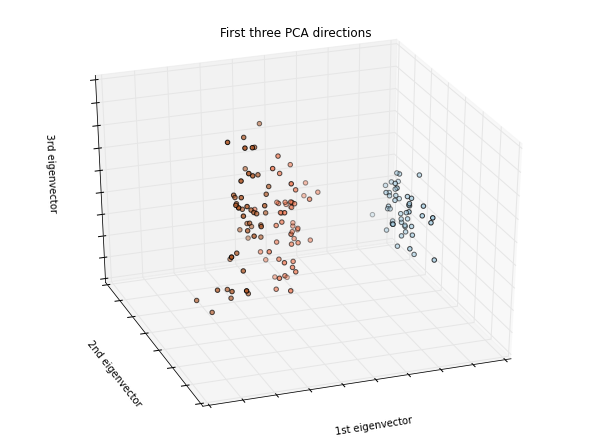

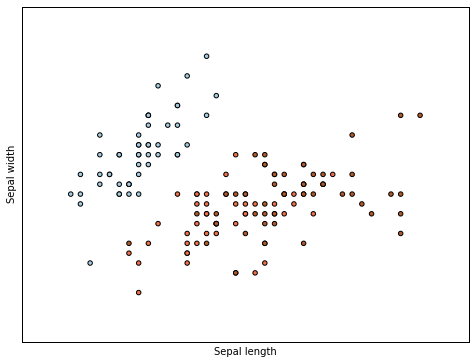

In [346]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

In [352]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder(n_values=[11,3,4])

In [353]:
enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])  

OneHotEncoder(categorical_features='all', dtype=<type 'float'>,
       handle_unknown='error', n_values=[11, 3, 4], sparse=True)

In [354]:
enc.transform([[0, 1, 3]]).toarray()

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.]])

In [355]:
enc.transform([[10, 1, 3]]).toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.]])